## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
#%load_ext autoreload
#%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
from datetime import datetime

Load model parameters:

In [3]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/scripts/Parameters/model_params/ResNet50V2_wo_perturbations.json'
if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
p.keys()

dict_keys(['_comment', 'model_path', 'clean_model_dir', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'log_file_name', 'log_level', 'disable_gpu', 'set_memory_growth', 'model_name', 'number_of_epochs', 'loss', 'BATCH_SIZE', 'seed', 'input_channels'])

Set logging:

In [4]:
# Set logging configuration
import logging
log_file_path = p['log_file_name']
logging.basicConfig(
    filename=log_file_path,
    filemode='w', 
    level=getattr(logging, p['log_level'])
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

#### Model parameters:

In [5]:
msg = 'Dataset:\n{}'.format(p['tf_ds_name'])
msg += '\nAugmentation:\nRandom Flipping: {}\nRandom 90deg Rotations: {}'.format(p['random_horizontal_flipping'],p['random_90deg_rotations'])
msg += '\nModel:\nArchitecture: {}'.format(p['model_name'])
msg += '\nLoss function: {}'.format(p['loss'])
msg += '\nEpochs: {}\n\n'.format(p['number_of_epochs'])
logging.info(msg)
print(msg)

Dataset:
MPP_dataset_no_perturbations
Augmentation:
Random Flipping: 1
Random 90deg Rotations: 1
Model:
Architecture: ResNet50V2
Loss function: huber
Epochs: 80




In [6]:
# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    msg = 'External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH)
    logging.error(msg)
    raise Exception(msg)
else:
    msg='EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH)
    print(msg)
    logging.info(msg)
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
# Load external libraries
import Models as models_functions
from Models import Predef_models as predef_models
from Utils import Tee_Logger as Tee_Logger
import Utils as utils

EXTERNAL_LIBS_PATH: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs


Create dirs where model output will be saved:

In [7]:
# If you want to avoid cleaning (deleting) model dir, then uncomment the next line:
#p['clean_model_dir'] = 0

base_path, model_path, checkpoints_path = utils.create_model_dirs(parameters=p)

msg = 'Base path:\n{}'.format(base_path)
msg += '\nModel path:\n{}'.format(model_path)
msg += '\nCheckpoints path:\n{}'.format(checkpoints_path)
logging.info(msg)
print(msg)

Base path:
/storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350
Model path:
/storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/model
Checkpoints path:
/storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/checkpoints


In [8]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    logging.info(msg)
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
logging.info(msg)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'
        
    logging.info(msg)
    print(msg)

Physical GPU devises:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Preprocessing parameters and information:

In [9]:
# Preprocessed data path
pp_path = p['pp_path']

with open(os.path.join(pp_path, 'params.json')) as pp_file:
    pp_params = json.load(pp_file)
msg = 'Loaded data preprocessing parameters from:\n{}'.format(pp_file)
logging.info(msg)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as channel_file:
    channels = pd.read_csv(channel_file)
msg = 'Loaded channels file from:\n{}'.format(channel_file)
logging.info(msg)

## Specify input channels

In [10]:
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
logging.info(msg)
print(msg)
print(input_ids.shape)

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(33,)


## Load Dataset

In [11]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=p['shuffle_files'],
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
logging.info(msg)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

Show information about the dataset:

In [12]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset_no_perturbations',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' s

In [13]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=376>,
 'train': <tfds.core.SplitInfo num_examples=2959>,
 'validation': <tfds.core.SplitInfo num_examples=368>}

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [14]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)
    
    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images."""
    
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    if p['random_horizontal_flipping']:
        image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    if p['random_90deg_rotations']:
        k = np.random.randint(0,4)
        image = tf.image.rot90(image, k=k)
    
    return image, target

In [15]:
msg = ''
if p['random_horizontal_flipping']:
    msg = 'Random horizontal flipping for training set selected!'
if p['random_90deg_rotations']:
    msg = msg + '\nRandom 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!'
if msg == '':
    msg = 'No data augmentation technique selected for trainingset!'
logging.info(msg)
print(msg)

Random horizontal flipping for training set selected!
Random 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!


Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [16]:
def visualize_cell(image):
    plt.figure(figsize=(6,4))
    plt.title('Original Cell')
    plt.imshow(image.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    
    if p['random_horizontal_flipping'] | p['random_90deg_rotations']:
        plt.figure(figsize=(15,4))
        for i in range(4):
            img, _ = augment(image, 0)
            plt.subplot(1,4,i+1)
            plt.title('Augmented Cell')
            plt.imshow(img.numpy()[:,:,10:13],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)

In [17]:
# Get one image from the training dataset
image, _ = next(iter(train_data))

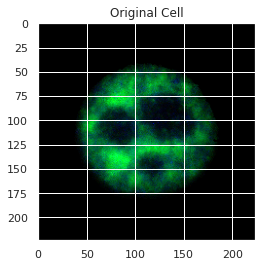

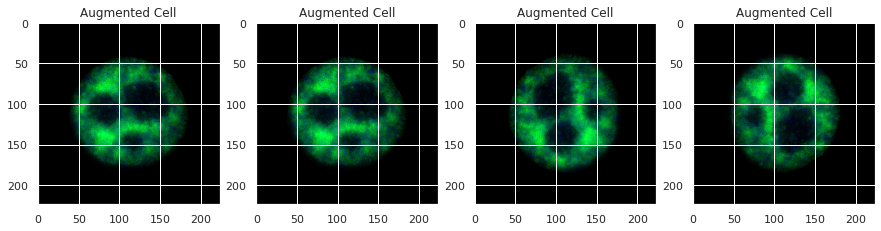

In [18]:
# Visualize the original vs. random flipping and rotations
visualize_cell(image)

Prepare datasets for training the CNN:

In [19]:
BATCH_SIZE = p['BATCH_SIZE']
buffer_size = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [20]:
# Init models class
models = predef_models()

# Select model
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)
model = models.select_model(model_name=p['model_name'], input_shape=img_shape)

ResNet50V2 selected!


Select the loss function and build the model:

In [21]:
# Select the loss function
if p['loss'] == 'mse':
    loss = tf.keras.losses.MeanSquaredError()
    
elif p['loss'] == 'huber':
    loss = tf.keras.losses.Huber(delta=1.0)
msg = '{} loss function selected. Building the model...'.format(p['loss'])
logging.info(msg)
print(msg)

metrics = ['mse', 'mean_absolute_error']
model.compile(optimizer='adam',
              loss=loss,
              metrics=metrics
             )
msg = 'Model compiled!'
logging.info(msg)

huber loss function selected. Building the model...


Take a look into the model architecture and number of parameters:

In [22]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 224, 224, 33 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 33) 0           InputLayer[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 103552      conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
# Finish stdout duplication
TeeLog.close()

Redirect the systems standard output to the logfile, so we can see the training process in the server:

Set callback to save best model:

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoints_path+'/checkpoint',
#    save_weights_only=True,
    filepath=checkpoints_path+'/best_model',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
)

Train the model:

In [25]:
msg = 'Starting model training...'
logging.info(msg)

In [26]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)

# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=p['number_of_epochs'],
                    callbacks=[model_checkpoint_callback],
                    #verbose=1, #progress bar
                    verbose=2, #one line per epoch
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )

Epoch 1/80
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/checkpoints/best_model/assets
47/47 - 48s - loss: 272.0600 - mse: 84608.3359 - mean_absolute_error: 272.5600 - val_loss: 241671.7344 - val_mse: 65380048896.0000 - val_mean_absolute_error: 241672.2188
Epoch 2/80
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/checkpoints/best_model/assets
47/47 - 46s - loss: 63.3775 - mse: 7132.4663 - mean_absolute_error: 63.8755 - val_loss: 20535.6543 - val_mse: 606708096.0000 - val_mean_absolute_error: 20536.1543
Epoch 3/80
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/checkpoints/best_model/assets
47/47 - 48

In [27]:
# Finish stdout duplication
TeeLog.close()

In [28]:
msg = 'Saiving trained model'
logging.info(msg)

# Save model
model.save(model_path)

INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/ResNet50V2/121220_2350/model/assets


In [29]:
# Load best weights
#model.load_weights(checkpoints_path+'/checkpoint')
model.load_weights(os.path.join(checkpoints_path, 'best_model/variables/variables'))

In [30]:
# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history.history, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [31]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

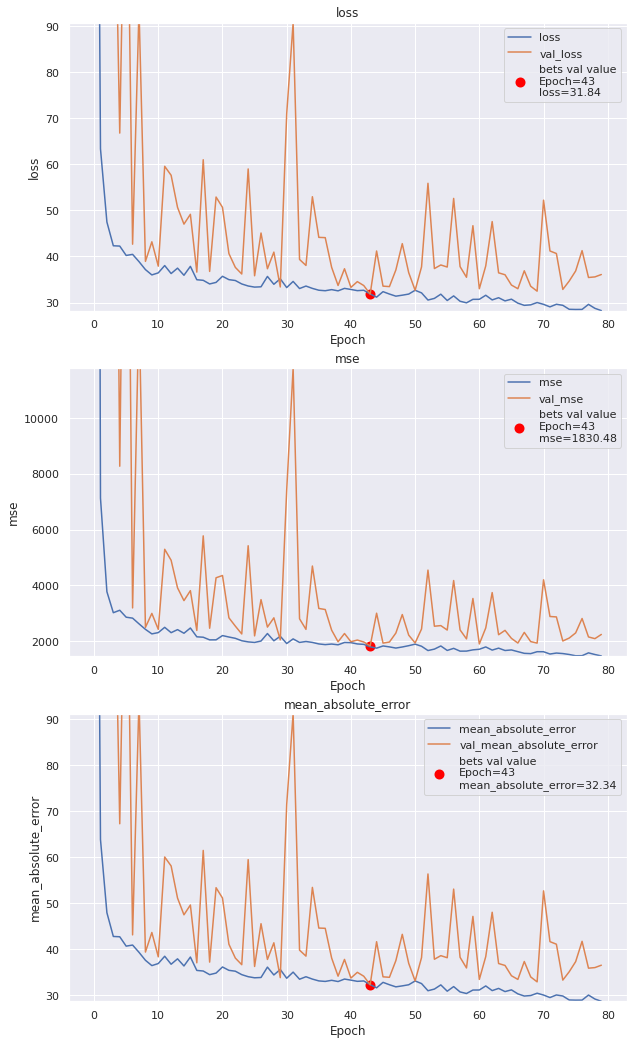

In [32]:
plt.figure(figsize=(10,18))
models_functions.plot_loss(history.history, metrics, p)

## Evaluate the whole Dataset

In [33]:
del(train_data, val_data, test_data)
del(dataset, metadata)

In [34]:
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [35]:
BATCH_SIZE = p['BATCH_SIZE']
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [36]:
columns = ['y', 'y_hat', 'mapobject_id_cell', 'set']
targets_df = pd.DataFrame(columns=columns)

dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
for ds, dsn in zip(dss, ds_names):
    for cells in ds:
        cell_ids = [cell_id.decode() for cell_id in cells['mapobject_id_cell'].numpy()]
        cell_ids = np.asarray(cell_ids).reshape(-1,1)
        Y = cells['target'].numpy()
        cell_imgs, _ = filter_channels(cells['image'], _)
        Y_hat = model.predict(cell_imgs)
        temp_df = pd.DataFrame(np.concatenate((Y, Y_hat), axis=1), columns=['y', 'y_hat'])
        temp_df['mapobject_id_cell'] = cell_ids
        temp_df['set'] = dsn
        targets_df = pd.concat((targets_df, temp_df), axis=0, ignore_index=True)

In [37]:
# Add perturbation info to the targets df
with open(os.path.join(p['pp_path'], 'metadata.csv'), 'r') as file:
    row_data_metadata = pd.read_csv(file)
    row_data_metadata.mapobject_id_cell = row_data_metadata.mapobject_id_cell.astype(str)
per_df = row_data_metadata[['mapobject_id_cell', 'perturbation']]
targets_df = targets_df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
)
targets_df

,y,y_hat,mapobject_id_cell,set,perturbation
0,337.603180,379.081268,305670,train,DMSO
1,489.283569,451.634674,200732,train,normal
2,343.809692,364.140533,224274,train,normal
3,436.179108,446.811218,248989,train,DMSO
4,344.612427,329.460114,212764,train,normal
...,...,...,...,...,...
3698,385.462708,351.526855,261401,test,normal
3699,414.214355,396.613922,194787,test,normal
3700,391.196686,372.337830,375051,test,DMSO
3701,401.894257,409.453339,251481,test,normal


In [38]:
# Sava targets info
with open(os.path.join(base_path, 'targets.csv'), 'w') as file:
    targets_df.to_csv(file, index=False)

## Plot results
Now lets see how our model performs.

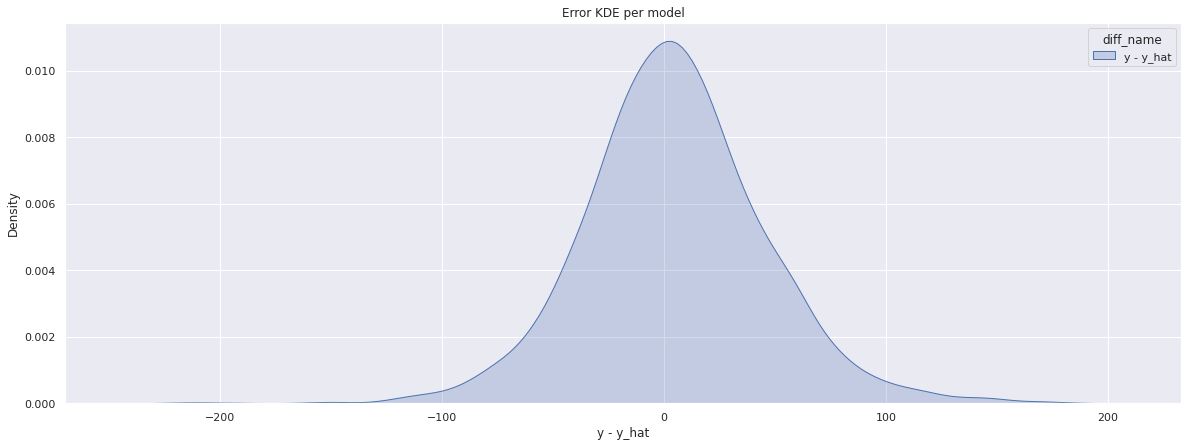

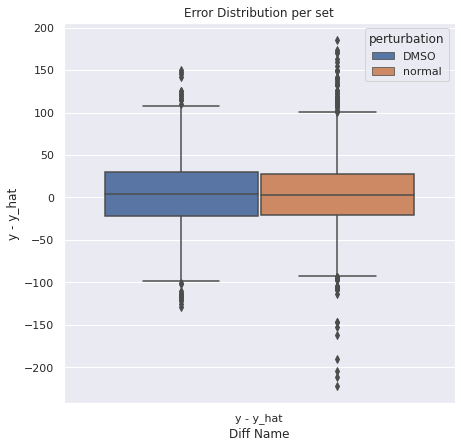

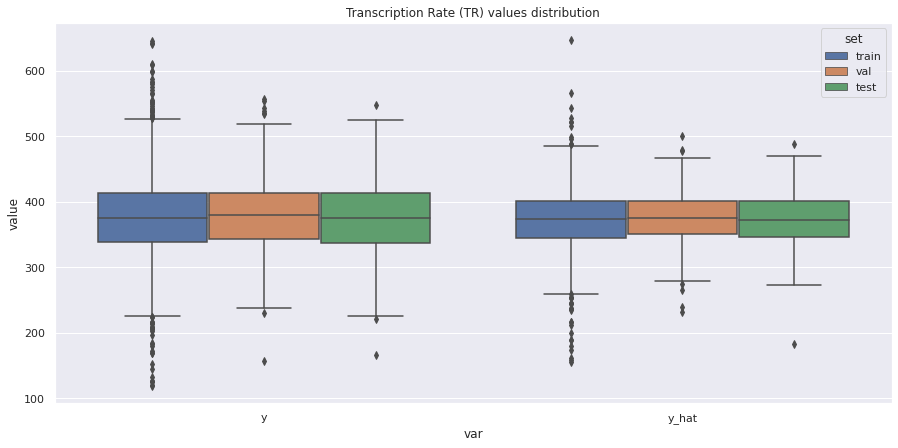

In [39]:
models_functions.plot_error_dist(df=targets_df, y_models=['y_hat'])

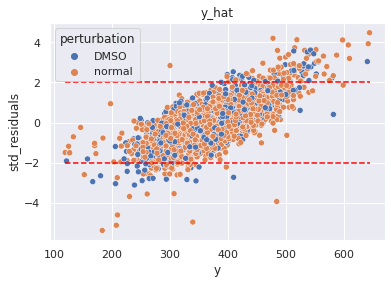

In [40]:
# Residual plot
models_functions.plot_residuals(df=targets_df, y_hat='y_hat')

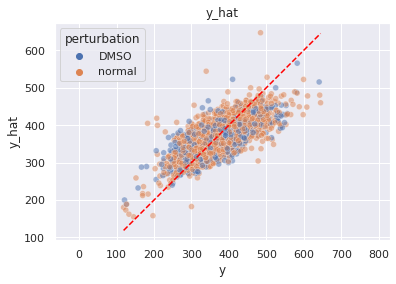

In [41]:
# Target vs predicted
models_functions.plot_y_vs_y_hat(df=targets_df, y_hat='y_hat')

In [42]:
metric_values = models_functions.get_metrics(df=targets_df)
# Sava metrics info
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metric_values.to_csv(file, index=False)
metric_values

,model,set,R2,BIC,MSE,MAE,Huber
0,y_hat,test,0.4803,0,1591.2937,30.5844,30.0906
1,y_hat,train,0.5403,0,1743.4141,31.5174,31.0209
2,y_hat,val,0.4739,0,1830.4751,32.3369,31.8384


In [43]:
msg = 'Notebook execution finished!'
logging.info(msg)